In [1]:
# Compare AMP with other sparse recovery algorithms in compressed sensing.
#
# Includes:
# 1) Approximate message passing with soft-thresholding (AMP)
# 2) Iterative soft-thresholding (IST)
# 3) Proximal gradient descent (for solving the LASSO)
# 4) Accelerated proximal gradient descent (with Nesterov momentum)
# 5) Orthogonal matching pursuit (OMP)
# 6) CoSaMP
#
# Copyright (c) 2021 Kuan Hsieh

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import time
from amp4cs import initialise_CS, opt_tuning_param, soft_thresh, amp
from cs_algos import ist, prox_grad, nesterov, omp, cosamp

In [2]:
N         = 1000 # dimension of signal
M         = 500  # num of measurements
K         = 40   # num of non-zero coefficients
sigma     = 0.05 # measurement noise standard deviation
iter_max  = 140  # max num of iterations

# Generate signal vector x, sensing matrix A and measurement vector y
y, A, x_init = initialise_CS(N,M,K,sigma)

In [3]:
# Run AMP and IST first

alpha_amp = opt_tuning_param(K/N) # Find optimal alpha parameter for AMP
alpha_ist = 2.0                   # Find optimal alpha parameter for IST
mse_amp   = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE
mse_ist   = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE

x_amp     = np.zeros_like(x_init) # Initial signal estimate
z_amp     = y                     # Initial residual 
x_ist     = np.zeros_like(x_init) # Initial signal estimate
z_ist     = y                     # Initial residual
for t in range(iter_max-1):
    (x_amp, z_amp) = amp(y, A, x_amp, z_amp, alpha_amp) # AMP
    (x_ist, z_ist) = ist(y, A, x_ist, z_ist, alpha_ist) # AMP
    mse_amp[t+1] = np.mean((x_amp-x_init)**2)     # Empirical MSE
    mse_ist[t+1] = np.mean((x_ist-x_init)**2)     # Empirical MSE

In [4]:
# Run convex solvers for the LASSO with regularisation parameter Lambda

# Set Lambda as follows to match the alpha parameter used for AMP.
# See Equation 5.8 of "Graphical Models Concepts in Compressed Sensing" 
# by Montanari for more details.
L = alpha_amp*LA.norm(z_amp)*(1-LA.norm(x_amp,0)/M)/np.sqrt(M) # Lambda

# Set the step size (guarantees convergence)
start = time.perf_counter()
stepsize = np.real(1/(np.max(LA.eigvals(np.dot(A.T,A))))) # Step size
print('time to calculate step size:', time.perf_counter() - start)

x_prox  = np.zeros_like(x_init) # Initial signal estimate 
x_nest  = np.zeros_like(x_init) # Initial signal estimate 
x_fista = np.zeros_like(x_init) # Initial signal estimate 
mse_prox  = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE
mse_nest  = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE

theta_nest  = x_nest  # Initialize for Nesterov momentum

for t in range(iter_max-1):
    x_prox = prox_grad(y, A, x_prox, stepsize, L) # Proximal gradient
    (x_nest, theta_nest)   = nesterov(y,A,x_nest,stepsize,L,t,theta_nest) # With Nesterov momentum
    mse_prox[t+1]  = np.mean((x_prox-x_init)**2)  # Empirical MSE
    mse_nest[t+1]  = np.mean((x_nest-x_init)**2)

time to calculate step size: 0.6055907660000059


In [5]:
# Run OMP and CoSaMP

tol   = LA.norm(y)*1e-6 # Convergence tolerance

x_omp = np.zeros_like(x_init) # Initial signal estimate
z_omp = y                     # Initial residual 
Omega = []                    # Initial set of selected indices
mse_omp = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE

x_cosamp   = np.zeros_like(x_init) # Initial signal estimate
z_cosamp   = y                     # Initial residual 
mse_cosamp = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE
K_est      = K                     # Estimated number of non-zero entries

for t in range(iter_max-1):
    (x_omp, z_omp, Omega) = omp(y, A, x_omp, z_omp, Omega)
    (x_cosamp, z_cosamp) = cosamp(A, y, K_est, x_cosamp, z_cosamp)
    mse_omp[t+1] = np.mean((x_omp-x_init)**2)     # Empirical MSE
    mse_cosamp[t+1] = np.mean((x_cosamp-x_init)**2)     # Empirical MSE
    
#     if LA.norm(z_omp) < tol and LA.norm(z_cosamp) < tol:
#         break

x_cosamp2   = np.zeros_like(x_init) # Initial signal estimate
z_cosamp2   = y                     # Initial residual 
mse_cosamp2 = np.ones(iter_max)*np.mean(x_init**2) # Store signal reconstruction MSE
K_est2      = K*2                   # Estimated number of non-zero entries

for t in range(iter_max-1):
    (x_cosamp2, z_cosamp2) = cosamp(A, y, K_est2, x_cosamp2, z_cosamp2)
    mse_cosamp2[t+1] = np.mean((x_cosamp2-x_init)**2)     # Empirical MSE

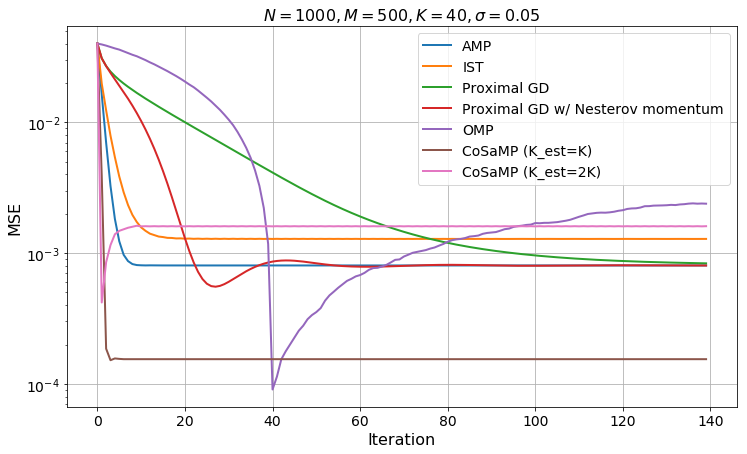

In [6]:
# Plot all
plt.figure(figsize=(12,7))
plt.plot(mse_amp, linewidth=2.0, label='AMP')
plt.plot(mse_ist, linewidth=2.0, label='IST')
plt.plot(mse_prox,linewidth=2.0, label='Proximal GD')
plt.plot(mse_nest,linewidth=2.0, label='Proximal GD w/ Nesterov momentum')
plt.plot(mse_omp,linewidth=2.0, label='OMP')
plt.plot(mse_cosamp,linewidth=2.0, label='CoSaMP (K_est=K)')
plt.plot(mse_cosamp2,linewidth=2.0, label='CoSaMP (K_est=2K)')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.title(r'$N = {}, M = {}, K = {}, \sigma = {}$'.format(N,M,K,sigma), fontsize=16)
plt.grid(True)